#### Note: All data in this repo is synthetically made including sleep stage annotations, demographics or diseases. The data is for demo purposes only.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ─── Debug Configuration ─────────────────────────────────────────────────────
# Set DEBUG = False to suppress verbose plots/logs after you're confident about a phase
DEBUG = True

# Threshold for Phecode Coverage count in Phase 3
HAZARD_THRESHOLD = 3.0

# Helper: ANSI colour shortcuts
def _ok(msg):   print(f"\033[1;32m[SUCCESS]\033[0m {msg}")
def _warn(msg): print(f"\033[1;33m[WARNING]\033[0m {msg}")
def _err(msg):  print(f"\033[1;31m[ERROR]\033[0m {msg}")
def _info(msg): print(f"\033[1;34m[INFO]\033[0m {msg}")

#### Preprocessing Details


Before running this notebook, please preprocess your PSG files using the scripts provided in `sleepfm/preprocessing`. Note that PSG recordings may contain different sets of channels across datasets. The predefined channel–modality mappings used in this project are specified in `sleepfm/configs/channel_groups.json`.

Although we have attempted to make this mapping as comprehensive as possible, we strongly recommend reviewing the channels present in your specific PSG data. In consultation with domain experts, you should group any additional or dataset-specific channels into the appropriate modality categories and update `channel_groups.json` accordingly. This step is critical to ensure that all channels are correctly aligned with their intended modalities during preprocessing and downstream modeling.

In [3]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import os
import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from collections import Counter
import pandas as pd
sys.path.append("..")
sys.path.append("../sleepfm")
from preprocessing.preprocessing import EDFToHDF5Converter
from models.dataset import SetTransformerDataset, collate_fn
from models.models import SetTransformer, SleepEventLSTMClassifier, DiagnosisFinetuneFullLSTMCOXPHWithDemo
import h5py
from utils import load_config, load_data, save_data, count_parameters
from torch.utils.data import Dataset, DataLoader

#### Part 0: Preprocessing EDF files

Note: This is just a demo notebook that preprocesses a single, specific file. run `sleepfm/preprocessing/preprocessing.sh` with appropriate folders to generate multiple preprocessed files.

In [4]:
base_save_path = "demo_data"
os.makedirs(base_save_path, exist_ok=True)

In [5]:
# root_dir = "/edf_root"      # dummy root not used for a single file conversion
# target_dir = "/note"    # dummy target not used for a single file conversion

# edf_path = "demo_data/demo_psg.edf"
# hdf5_path = os.path.join(base_save_path, "demo_psg.hdf5")

# converter = EDFToHDF5Converter(
#     root_dir=root_dir,
#     target_dir=target_dir,
#     resample_rate=128
# )

# # run for single file conversion
# converter.convert(edf_path, hdf5_path)

root_dir = "/edf_root"      # dummy root not used for a single file conversion
target_dir = "/note"    # dummy target not used for a single file conversion

edf_path = "demo_data/demo_psg.edf"
base_save_path = "output" # กำหนด path สำหรับบันทึกไฟล์
os.makedirs(base_save_path, exist_ok=True)
hdf5_path = os.path.join(base_save_path, "demo_psg.hdf5")

converter = EDFToHDF5Converter(
    root_dir=root_dir,
    target_dir=target_dir,
    resample_rate=128
)

# run for single file conversion
converter.convert(edf_path, hdf5_path)

# --- DEBUG SECTION: ตรวจสอบค่าสถิติหลังแปลงไฟล์ ---
print("\n" + "="*50)
print(f"DEBUGGING HDF5: {hdf5_path}")
print("="*50)

with h5py.File(hdf5_path, 'r') as f:
    # สมมติว่าโครงสร้าง HDF5 เก็บสัญญาณไว้ใน group หรือ dataset หลัก 
    # (ปรับเปลี่ยนตามโครงสร้างจริงของ EDFToHDF5Converter ที่คุณใช้)
    for key in f.keys():
        data = f[key][:]
        
        print(f"Channel: {key}")
        print(f"  - Shape: {data.shape}")
        print(f"  - Data Type: {data.dtype}")
        
        # คำนวณค่าสถิติพื้นฐาน
        mean_val = np.mean(data)
        std_val = np.std(data)
        min_val = np.min(data)
        max_val = np.max(data)
        
        print(f"  - Statistics:")
        print(f"    Mean: {mean_val:.4f}")
        print(f"    Std:  {std_val:.4f}")
        print(f"    Min:  {min_val:.4f}")
        print(f"    Max:  {max_val:.4f}")
        
        # เช็คกรณีข้อมูลเป็น NaN หรือ Inf
        if np.isnan(data).any():
            print("  - [WARNING]: Found NaN values!")
        if np.isinf(data).any():
            print("  - [WARNING]: Found Infinity values!")
        print("-" * 30)

print("Check completed.")

2026-02-23 14:43:35.370 | INFO     | preprocessing.preprocessing:read_edf:146 - reading edf


Extracting EDF parameters from /home/nummm/Documents/CEPP/sleepfm-clinical/notebooks/demo_data/demo_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2234623  =      0.000 ...  8728.996 secs...


2026-02-23 14:43:35.791 | INFO     | preprocessing.preprocessing:resample_signals:184 - resampling signals


Filtering signal
Filtering signal
Filtering signal
Filtering signal


2026-02-23 14:43:36.015 | INFO     | preprocessing.preprocessing:save_to_hdf5:219 - saving hdf5
/home/nummm/Documents/CEPP/sleepfm-clinical/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)



DEBUGGING HDF5: output/demo_psg.hdf5
Channel: Airflow
  - Shape: (1117312,)
  - Data Type: float16
  - Statistics:
    Mean: 0.0000
    Std:  inf
    Min:  -4.7148
    Max:  4.9688
------------------------------
Channel: Arm EMG
  - Shape: (1117312,)
  - Data Type: float16
  - Statistics:
    Mean: -0.0000
    Std:  inf
    Min:  -4.7617
    Max:  5.1016
------------------------------
Channel: C3-A2
  - Shape: (1117312,)
  - Data Type: float16
  - Statistics:
    Mean: -0.0000
    Std:  inf
    Min:  -5.1172
    Max:  4.7578
------------------------------
Channel: EKG
  - Shape: (1117312,)
  - Data Type: float16
  - Statistics:
    Mean: 0.0000
    Std:  inf
    Min:  -4.7969
    Max:  5.1641
------------------------------
Check completed.


#### 🔍 Phase 1A: Channel Mapping Status

Compares channels found in the HDF5 file against the definitions in `channel_groups.json`.

In [6]:
model_path = "../sleepfm/checkpoints/model_base"
channel_groups_path = "../sleepfm/configs/channel_groups.json"
config_path = os.path.join(model_path, "config.json")

In [7]:
_info("Phase 1A — Channel Mapping Status")

import json as _json

with open(channel_groups_path, "r") as _f:
    _channel_groups_raw = _json.load(_f)

# Flatten expected channels from channel_groups.json
_expected = {ch: mod for mod, ch_list in _channel_groups_raw.items() for ch in ch_list}

# Actual channels in HDF5
with h5py.File(hdf5_path, "r") as _hf:
    _actual_channels = list(_hf.keys())

_rows = []
for ch in _actual_channels:
    mod = _expected.get(ch, None)
    _rows.append({
        "Channel": ch,
        "Modality": mod if mod else "—",
        "Status": "✅ Mapped" if mod else "❌ Unmapped",
    })

# Expected channels missing from file
for ch, mod in _expected.items():
    if ch not in _actual_channels:
        _rows.append({"Channel": ch, "Modality": mod, "Status": "⚠️ Missing in file"})

# _mapping_df = pd.DataFrame(_rows)

# def _style_status(val):
#     if "Unmapped" in str(val):   return "background-color: #ffcccc; color: #7b0000"
#     if "Missing"  in str(val):   return "background-color: #fff3cd; color: #7a4f00"
#     return "background-color: #ccffcc; color: #1a4d1a"

# _n_unmapped = (_mapping_df["Status"] == "❌ Unmapped").sum()
# _n_missing  = (_mapping_df["Status"] == "⚠️ Missing in file").sum()

# if _n_unmapped > 0: _warn(f"{_n_unmapped} channel(s) in HDF5 are UNMAPPED in channel_groups.json")
# if _n_missing  > 0: _warn(f"{_n_missing} channel(s) defined in config but NOT FOUND in HDF5")
# if _n_unmapped == 0 and _n_missing == 0: _ok("All channels are correctly mapped!")

# display(_mapping_df.style
#     .applymap(_style_status, subset=["Status"])
#     .set_caption("📋 Channel Mapping Report (Phase 1A)")
#     .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))


[INFO] Phase 1A — Channel Mapping Status


#### 📊 Phase 1B: Signal Integrity Stats

Min, Max, Mean, Std, NaN count, and Zero-padding count for every channel in the HDF5 file.

In [8]:
_info("Phase 1B — Signal Integrity Stats")

_stats_rows = []

with h5py.File(hdf5_path, "r") as _hf:
    _channel_keys = list(_hf.keys())
    for _key in tqdm.tqdm(_channel_keys, desc="Scanning channels"):
        _data = _hf[_key][:]
        _nan_count  = int(np.isnan(_data).sum())
        _zero_count = int((_data == 0).sum())
        _total      = _data.size
        _zero_pct   = _zero_count / _total * 100

        if _nan_count > 0:
            _status = "❌ NaN detected"
        elif _zero_pct > 10:
            _status = "⚠️ High zeros"
        else:
            _status = "✅ OK"

        _stats_rows.append({
            "Channel":   _key,
            "Shape":     str(_data.shape),
            "DType":     str(_data.dtype),
            "Min":       float(np.nanmin(_data)),
            "Max":       float(np.nanmax(_data)),
            "Mean":      float(np.nanmean(_data)),
            "Std":       float(np.nanstd(_data)),
            "NaNs":      _nan_count,
            "Zeros %":   round(_zero_pct, 2),
            "Status":    _status,
        })

_stats_df = pd.DataFrame(_stats_rows)

def _style_sig_status(val):
    if "NaN" in str(val):   return "background-color: #ffcccc; font-weight: bold"
    if "High" in str(val):  return "background-color: #fff3cd"
    return "background-color: #ccffcc"

display(_stats_df.style
    .format({"Min": "{:.4f}", "Max": "{:.4f}", "Mean": "{:.4f}", "Std": "{:.4f}", "Zeros %": "{:.2f}%"})
    .applymap(_style_sig_status, subset=["Status"])
    .set_caption("📊 Signal Integrity Report (Phase 1B)")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))

_ok("Signal integrity check complete.")


[INFO] Phase 1B — Signal Integrity Stats


Scanning channels:   0%|          | 0/4 [00:00<?, ?it/s]/home/nummm/Documents/CEPP/sleepfm-clinical/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Scanning channels: 100%|██████████| 4/4 [00:00<00:00, 20.65it/s]
/tmp/ipykernel_17870/3513905516.py:41: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(_stats_df.style


,Channel,Shape,DType,Min,Max,Mean,Std,NaNs,Zeros %,Status
0,Airflow,"(1117312,)",float16,-4.7148,4.9688,-0.0000,inf,0,0.00%,✅ OK
1,Arm EMG,"(1117312,)",float16,-4.7617,5.1016,-0.0000,inf,0,0.00%,✅ OK
2,C3-A2,"(1117312,)",float16,-5.1172,4.7578,-0.0000,inf,0,0.00%,✅ OK
3,EKG,"(1117312,)",float16,-4.7969,5.1641,0.0000,inf,0,0.00%,✅ OK


[SUCCESS] Signal integrity check complete.


#### 📈 Phase 1C: 30-second Raw Signal Preview

Quick visual check for Noise, Flatline, or obvious artefacts. Only shown when `DEBUG = True`.

/tmp/ipykernel_17870/426256583.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/home/nummm/Documents/CEPP/sleepfm-clinical/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


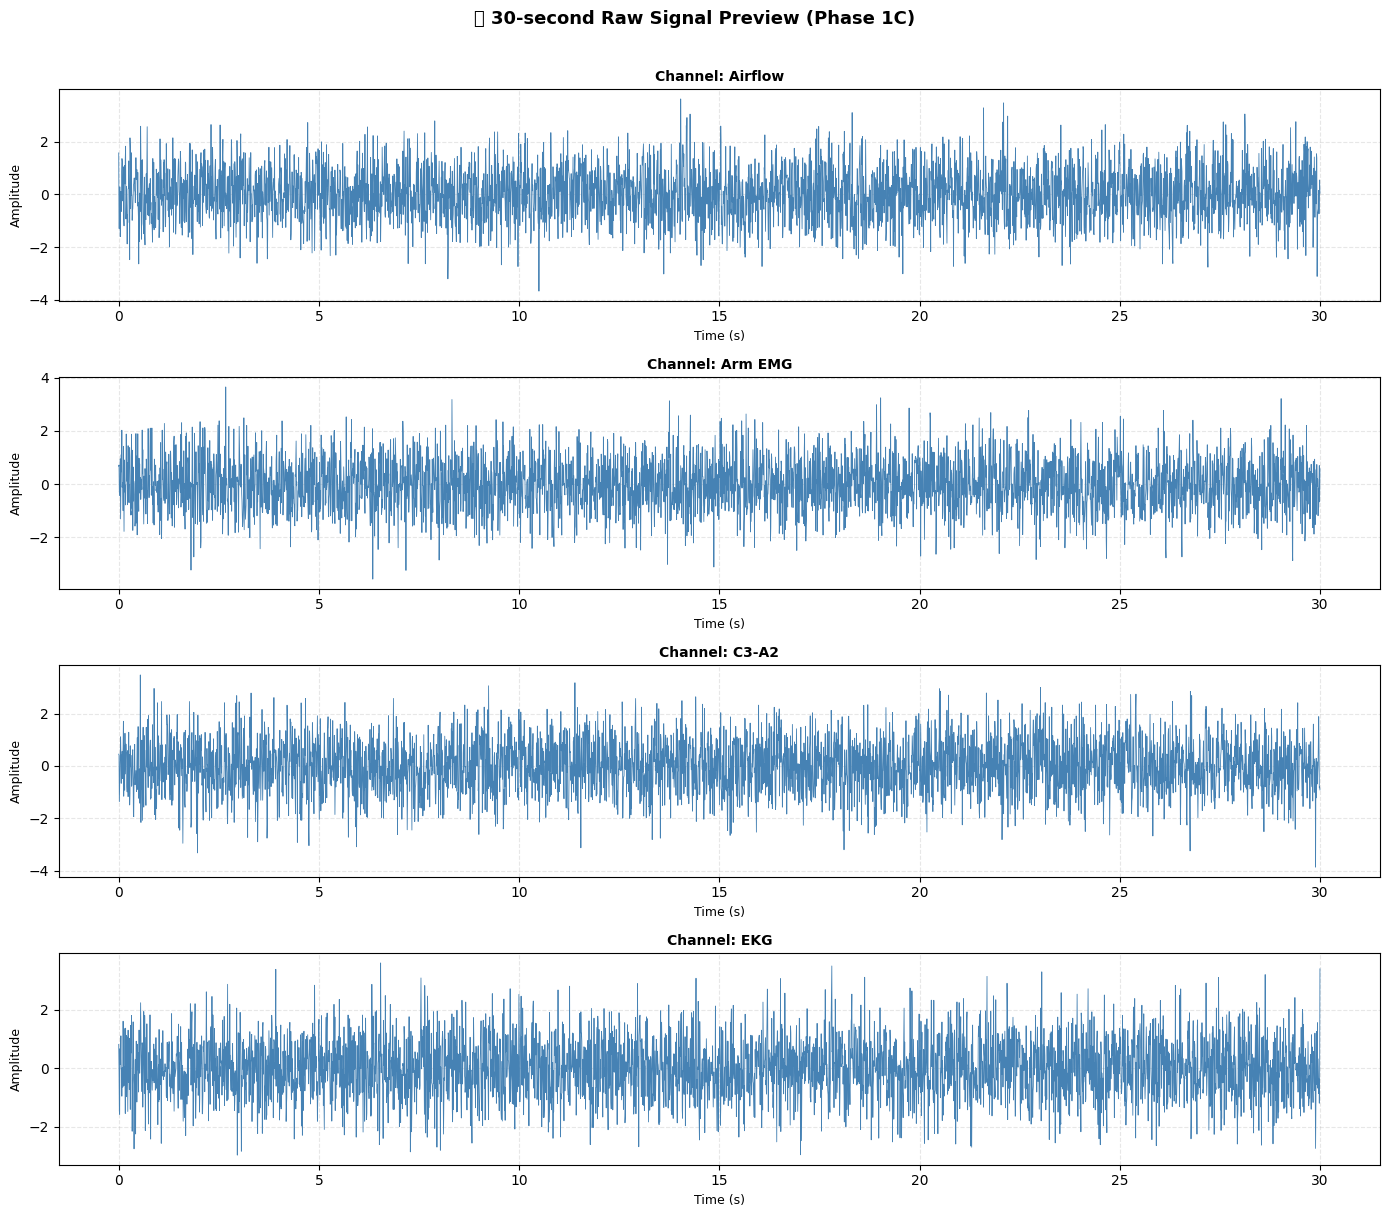

In [9]:
if DEBUG:
    _SAMPLE_RATE   = 128
    _PREVIEW_SECS  = 30
    _n_preview     = _SAMPLE_RATE * _PREVIEW_SECS

    with h5py.File(hdf5_path, "r") as _hf:
        _ch_keys = list(_hf.keys())
        _fig, _axes = plt.subplots(len(_ch_keys), 1, figsize=(14, 3 * len(_ch_keys)))
        if len(_ch_keys) == 1:
            _axes = [_axes]
        for _ax, _key in zip(_axes, _ch_keys):
            _sig = _hf[_key][:_n_preview]
            _t   = np.linspace(0, _PREVIEW_SECS, len(_sig))
            _ax.plot(_t, _sig, linewidth=0.6, color="steelblue")
            _ax.set_title(f"Channel: {_key}", fontsize=10, fontweight="bold")
            _ax.set_xlabel("Time (s)", fontsize=9)
            _ax.set_ylabel("Amplitude", fontsize=9)
            _ax.grid(True, alpha=0.3, linestyle="--")
        _fig.suptitle("📈 30-second Raw Signal Preview (Phase 1C)", fontsize=13, y=1.01, fontweight="bold")
        plt.tight_layout()
        plt.show()
else:
    _info("Phase 1C plots suppressed (DEBUG=False)")


#### Part 1: Generating embeddings from SleepFM pretrained model

Here we show generating embedding for 1 demno PSG. To see full script, please check `sleepfm/pipeline/generate_embeddings.py`. 

In [10]:
model_path = "../sleepfm/checkpoints/model_base"
channel_groups_path = "../sleepfm/configs/channel_groups.json"
config_path = os.path.join(model_path, "config.json")

config = load_config(config_path)
channel_groups = load_data(channel_groups_path)

In [11]:
modality_types = config["modality_types"]
in_channels = config["in_channels"]
patch_size = config["patch_size"]
embed_dim = config["embed_dim"]
num_heads = config["num_heads"]
num_layers = config["num_layers"]
pooling_head = config["pooling_head"]
dropout = 0.0

In [12]:
model_class = getattr(sys.modules[__name__], config['model'])
model = model_class(in_channels, patch_size, embed_dim, num_heads, num_layers, pooling_head=pooling_head, dropout=dropout)

device = torch.device("cuda")
if device.type == "cuda":
    model = torch.nn.DataParallel(model)

model.to(device)
total_layers, total_params = count_parameters(model)
print(f'Trainable parameters: {total_params / 1e6:.2f} million')
print(f'Number of layers: {total_layers}')

Trainable parameters: 4.44 million
Number of layers: 93


In [13]:
checkpoint = torch.load(os.path.join(model_path, "best.pt"))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

DataParallel(
  (module): SetTransformer(
    (patch_embedding): Tokenizer(
      (tokenizer): Sequential(
        (0): Conv1d(1, 4, kernel_size=(5,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): LayerNorm((4, 320), eps=1e-05, elementwise_affine=True)
        (4): Conv1d(4, 8, kernel_size=(5,), stride=(2,), padding=(2,))
        (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ELU(alpha=1.0)
        (7): LayerNorm((8, 160), eps=1e-05, elementwise_affine=True)
        (8): Conv1d(8, 16, kernel_size=(5,), stride=(2,), padding=(2,))
        (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ELU(alpha=1.0)
        (11): LayerNorm((16, 80), eps=1e-05, elementwise_affine=True)
        (12): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
        (13): BatchNorm1d(32, eps=1

In [14]:
config

{'seed': 42,
 'model': 'SetTransformer',
 'in_channels': 1,
 'batch_size': 128,
 'epochs': 1,
 'lr': 0.001,
 'lr_step_period': 2,
 'gamma': 0.1,
 'temperature': 0.0,
 'momentum': 0.9,
 'num_workers': 16,
 'embed_dim': 128,
 'num_heads': 8,
 'num_layers': 6,
 'pooling_head': 8,
 'dropout': 0.3,
 'split_path': 'path_to_/dataset_split.json',
 'save_path': 'path_to_/models',
 'weight_decay': 0.0,
 'mode': 'leave_one_out',
 'save_iter': 5000,
 'eval_iter': 5000,
 'log_interval': 100,
 'use_wandb': True,
 'BAS_CHANNELS': 10,
 'RESP_CHANNELS': 7,
 'EKG_CHANNELS': 2,
 'EMG_CHANNELS': 4,
 'max_files': None,
 'val_size': 100,
 'sampling_duration': 5,
 'sampling_freq': 128,
 'patch_size': 640,
 'modality_types': ['BAS', 'RESP', 'EKG', 'EMG']}

In [15]:
hdf5_paths = [os.path.join(base_save_path, "demo_psg.hdf5")]
dataset = SetTransformerDataset(config, channel_groups, hdf5_paths=hdf5_paths, split="test")

dataloader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=16, 
                                            num_workers=1, 
                                            shuffle=False, 
                                            collate_fn=collate_fn)

Indexing files: 100%|██████████| 1/1 [00:00<00:00, 2449.94it/s]


#### 🔬 Phase 2A: Batch Tensor Shape, Type & Masking Distribution

Inspects the first batch from the embedding DataLoader — shapes, dtypes, real vs padding ratio.

In [16]:
_info("Phase 2A — Batch Tensor Validation (SetTransformer DataLoader)")

_sample_batch_p2a = next(iter(dataloader))
_bd_p2a, _ml_p2a, _fp_p2a, _dn_p2a, _cs_p2a = _sample_batch_p2a

_shape_rows = []
for _mod, _tensor, _mask in zip(config["modality_types"], _bd_p2a, _ml_p2a):
    _real_pct = float((_mask == 0).float().mean() * 100)
    _pad_pct  = float((_mask == 1).float().mean() * 100)
    _any_nan  = bool(_tensor.isnan().any())
    _shape_rows.append({
        "Modality":      _mod,
        "Tensor Shape":  str(tuple(_tensor.shape)),
        "Data Shape":    f"(Batch={_tensor.shape[0]}, Channels={_tensor.shape[1]}, Time={_tensor.shape[2]}, Features={_tensor.shape[3] if _tensor.dim()==4 else '-'})",
        "DType":         str(_tensor.dtype),
        "Real Data %":   f"{_real_pct:.1f}%",
        "Padding %":     f"{_pad_pct:.1f}%",
        "Has NaN?":      "❌ YES" if _any_nan else "✅ No",
    })

_shape_df = pd.DataFrame(_shape_rows)

def _style_nan(val):
    if "YES" in str(val): return "background-color: #ffcccc; font-weight: bold"
    return "background-color: #ccffcc"

def _style_pad(val):
    try:
        v = float(str(val).replace("%", ""))
        if v > 50: return "background-color: #fff3cd"
    except: pass
    return ""

display(_shape_df.style
    .applymap(_style_nan, subset=["Has NaN?"])
    .applymap(_style_pad, subset=["Padding %"])
    .set_caption("🔬 Batch Tensor Report (Phase 2A)")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))

_ok(f"Batch validation done. Batch size = {_tensor.shape[0]}")


[INFO] Phase 2A — Batch Tensor Validation (SetTransformer DataLoader)


/tmp/ipykernel_17870/3275476431.py:34: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(_shape_df.style


,Modality,Tensor Shape,Data Shape,DType,Real Data %,Padding %,Has NaN?
0,BAS,"(16, 1, 38400)","(Batch=16, Channels=1, Time=38400, Features=-)",torch.float32,100.0%,0.0%,✅ No
1,RESP,"(16, 1, 38400)","(Batch=16, Channels=1, Time=38400, Features=-)",torch.float32,100.0%,0.0%,✅ No
2,EKG,"(16, 1, 38400)","(Batch=16, Channels=1, Time=38400, Features=-)",torch.float32,100.0%,0.0%,✅ No
3,EMG,"(16, 1, 38400)","(Batch=16, Channels=1, Time=38400, Features=-)",torch.float32,100.0%,0.0%,✅ No


[SUCCESS] Batch validation done. Batch size = 16


#### 🧠 Phase 3A: Embedding Statistics

Basic stats of `SetTransformer` output embeddings per modality — helps detect vanishing/exploding gradients.

In [17]:
_info("Phase 3A — Embedding Statistics (SetTransformer outputs)")

_sb = next(iter(dataloader))
_bd3, _ml3, _, _, _ = _sb

model.eval()
with torch.no_grad():
    _signals  = [_bd3[i].to(device, dtype=torch.float) for i in range(4)]
    _masks    = [_ml3[i].to(device, dtype=torch.bool)  for i in range(4)]
    _emb_out  = [model(_signals[i], _masks[i]) for i in range(4)]
    # [1] = granular 5-sec-level embeddings, shape (Batch, Time, EmbDim)
    _emb_vecs = [_emb_out[i][1].cpu().numpy() for i in range(4)]

_emb_rows = []
for _mod, _vec in zip(config["modality_types"], _emb_vecs):
    _flat = _vec.reshape(-1)
    _emb_rows.append({
        "Modality":  _mod,
        "Shape":     str(_vec.shape),
        "Mean":      float(_flat.mean()),
        "Std":       float(_flat.std()),
        "Min":       float(_flat.min()),
        "Max":       float(_flat.max()),
        "L2 Norm":   float(np.linalg.norm(_flat)),
        "Status":    "⚠️ Check (large norm)" if np.linalg.norm(_flat) > 1e4 else
                     ("⚠️ Near-zero (vanishing?)" if abs(_flat.mean()) < 1e-6 else "✅ OK"),
    })

_emb_df = pd.DataFrame(_emb_rows)

def _style_emb_status(val):
    if "large" in str(val) or "vanishing" in str(val): return "background-color: #fff3cd; font-weight: bold"
    return "background-color: #ccffcc"

display(_emb_df.style
    .format({k: "{:.6f}" for k in ["Mean","Std","Min","Max","L2 Norm"]})
    .applymap(_style_emb_status, subset=["Status"])
    .set_caption("🧠 Embedding Statistics per Modality (Phase 3A)")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))

_ok("Embedding statistics check complete.")


[INFO] Phase 3A — Embedding Statistics (SetTransformer outputs)


/tmp/ipykernel_17870/4229414776.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(_emb_df.style


,Modality,Shape,Mean,Std,Min,Max,L2 Norm,Status
0,BAS,"(16, 60, 128)",-0.068419,1.649662,-6.103967,5.957033,578.773621,✅ OK
1,RESP,"(16, 60, 128)",-0.067869,1.637602,-5.862946,5.945870,574.541626,✅ OK
2,EKG,"(16, 60, 128)",-0.064361,1.645859,-6.142597,5.721986,577.384460,✅ OK
3,EMG,"(16, 60, 128)",-0.072692,1.641809,-5.908381,5.488091,576.087524,✅ OK


[SUCCESS] Embedding statistics check complete.


In [18]:
output = os.path.join(base_save_path, "demo_emb")
output_5min_agg = os.path.join(base_save_path, "demo_5min_agg_emb")
os.makedirs(output, exist_ok=True)
os.makedirs(output_5min_agg, exist_ok=True)

In [19]:
with torch.no_grad():
    with tqdm.tqdm(total=len(dataloader)) as pbar:
        for batch in dataloader:
            batch_data, mask_list, file_paths, dset_names_list, chunk_starts = batch
            (bas, resp, ekg, emg) = batch_data
            (mask_bas, mask_resp, mask_ekg, mask_emg) = mask_list

            bas = bas.to(device, dtype=torch.float)
            resp = resp.to(device, dtype=torch.float)
            ekg = ekg.to(device, dtype=torch.float)
            emg = emg.to(device, dtype=torch.float)

            mask_bas = mask_bas.to(device, dtype=torch.bool)
            mask_resp = mask_resp.to(device, dtype=torch.bool)
            mask_ekg = mask_ekg.to(device, dtype=torch.bool)
            mask_emg = mask_emg.to(device, dtype=torch.bool)

            embeddings = [
                model(bas, mask_bas),
                model(resp, mask_resp),
                model(ekg, mask_ekg),
                model(emg, mask_emg),
            ]

            # Model gives two kinds of embeddings. Granular 5 second-level embeddings and aggregated 5 minute-level embeddings. We save both of them below. 

            embeddings_new = [e[0].unsqueeze(1) for e in embeddings]

            for i in range(len(file_paths)):
                file_path = file_paths[i]
                chunk_start = chunk_starts[i]
                subject_id = os.path.basename(file_path).split('.')[0]
                output_path = os.path.join(output_5min_agg, f"{subject_id}.hdf5")

                with h5py.File(output_path, 'a') as hdf5_file:
                    for modality_idx, modality_type in enumerate(config["modality_types"]):
                        if modality_type in hdf5_file:
                            dset = hdf5_file[modality_type]
                            chunk_start_correct = chunk_start // (embed_dim * 5 * 60)
                            chunk_end = chunk_start_correct + embeddings_new[modality_idx][i].shape[0]
                            if dset.shape[0] < chunk_end:
                                dset.resize((chunk_end,) + embeddings_new[modality_idx][i].shape[1:])
                            dset[chunk_start_correct:chunk_end] = embeddings_new[modality_idx][i].cpu().numpy()
                        else:
                            hdf5_file.create_dataset(modality_type, data=embeddings_new[modality_idx][i].cpu().numpy(), chunks=(embed_dim,) + embeddings_new[modality_idx][i].shape[1:], maxshape=(None,) + embeddings_new[modality_idx][i].shape[1:])

            embeddings_new = [e[1] for e in embeddings]

            for i in range(len(file_paths)):
                file_path = file_paths[i]
                chunk_start = chunk_starts[i]
                subject_id = os.path.basename(file_path).split('.')[0]
                output_path = os.path.join(output, f"{subject_id}.hdf5")

                with h5py.File(output_path, 'a') as hdf5_file:
                    for modality_idx, modality_type in enumerate(config["modality_types"]):
                        if modality_type in hdf5_file:
                            dset = hdf5_file[modality_type]
                            chunk_start_correct = chunk_start // (embed_dim * 5)
                            chunk_end = chunk_start_correct + embeddings_new[modality_idx][i].shape[0]
                            if dset.shape[0] < chunk_end:
                                dset.resize((chunk_end,) + embeddings_new[modality_idx][i].shape[1:])
                            dset[chunk_start_correct:chunk_end] = embeddings_new[modality_idx][i].cpu().numpy()
                        else:
                            hdf5_file.create_dataset(modality_type, data=embeddings_new[modality_idx][i].cpu().numpy(), chunks=(embed_dim,) + embeddings_new[modality_idx][i].shape[1:], maxshape=(None,) + embeddings_new[modality_idx][i].shape[1:])
            pbar.update()

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


#### Part 2: Sleep Staging

Note that below, we are using our finetuned sleep staging model. It is always a good idea to finetune our model on your specific data, even if you only have a handful of sample, so that the model can adapt to your specific data distribution. Script to finetune your sleep staging model head is given in `sleepfm/pipeline/finetune_sleep_staging.py`. 

In [20]:
sleep_staging_model_path = "../sleepfm/checkpoints/model_sleep_staging"
sleep_staging_config = load_data(os.path.join(sleep_staging_model_path, "config.json"))

sleep_staging_model_params = sleep_staging_config['model_params']
sleep_staging_model_class = getattr(sys.modules[__name__], sleep_staging_config['model'])

sleep_staging_model = sleep_staging_model_class(**sleep_staging_model_params).to(device)
sleep_staging_model_name = type(sleep_staging_model).__name__

In [21]:
sleep_staging_model = nn.DataParallel(sleep_staging_model)
print(f"Using {torch.cuda.device_count()} GPUs")

Using 1 GPUs


In [22]:
print(f"Model initialized: {sleep_staging_model_name}")
total_layers, total_params = count_parameters(sleep_staging_model)
print(f'Trainable parameters: {total_params / 1e6:.2f} million')
print(f'Number of layers: {total_layers}')

Model initialized: SleepEventLSTMClassifier
Trainable parameters: 1.19 million
Number of layers: 20


In [23]:
sleep_staging_checkpoint_path = os.path.join(sleep_staging_model_path, "best.pth")
sleep_staging_checkpoint = torch.load(sleep_staging_checkpoint_path)
sleep_staging_model.load_state_dict(sleep_staging_checkpoint)

<All keys matched successfully>

Below are some helper functions for loading data for sleep staging. You can find similar functions within `sleepfm/models/dataset.py`. You may need to modify it slightly based on your usecase. 

In [24]:
class SleepEventClassificationDataset(Dataset):
    def __init__(
        self,
        config,
        channel_groups,
        hdf5_paths,
        label_files,
        split="train",
    ):
        self.config = config
        self.max_channels = self.config["max_channels"]
        self.context = int(self.config["context"])
        self.channel_like = self.config["channel_like"]

        self.max_seq_len = config["model_params"]["max_seq_length"]

        # --- Build label lookup: {study_id: label_csv_path} ---
        # study_id = filename without extension, e.g. "SSC_12345"
        labels_dict = {
            os.path.basename(p).rsplit(".", 1)[0]: p
            for p in label_files
            if os.path.exists(p)
        }

        # --- Filter to HDF5s that exist and have a matching label file ---
        hdf5_paths = [p for p in hdf5_paths if os.path.exists(p)]
        hdf5_paths = [
            p for p in hdf5_paths
            if os.path.basename(p).rsplit(".", 1)[0] in labels_dict
        ]

        if config.get("max_files"):
            hdf5_paths = hdf5_paths[: config["max_files"]]

        self.hdf5_paths = hdf5_paths
        self.labels_dict = labels_dict

        # --- Build index map ---
        # Each item is (hdf5_path, label_path, start_index)
        if self.context == -1:
            self.index_map = [
                (p, labels_dict[os.path.basename(p).rsplit(".", 1)[0]], -1)
                for p in self.hdf5_paths
            ]
        else:
            self.index_map = []
            loop = tqdm(self.hdf5_paths, total=len(self.hdf5_paths), desc=f"Indexing {split} data")
            for hdf5_file_path in loop:
                file_prefix = os.path.basename(hdf5_file_path).rsplit(".", 1)[0]
                label_path = labels_dict[file_prefix]

                with h5py.File(hdf5_file_path, "r") as hf:
                    dset_names = list(hf.keys())
                    if len(dset_names) == 0:
                        continue

                    # Use first dataset to define length (same as your original behavior)
                    first_name = dset_names[0]
                    dataset_length = hf[first_name].shape[0]

                for i in range(0, dataset_length, self.context):
                    self.index_map.append((hdf5_file_path, label_path, i))

        # If you have logger, keep; otherwise you can remove these.
        # logger.info(f"Number of files in {split} set: {len(self.hdf5_paths)}")
        # logger.info(f"Number of files to be processed in {split} set: {len(self.index_map)}")

        self.total_len = len(self.index_map)

    def __len__(self):
        return self.total_len

    def get_index_map(self):
        return self.index_map

    def __getitem__(self, idx):
        hdf5_path, label_path, start_index = self.index_map[idx]

        labels_df = pd.read_csv(label_path)
        labels_df["StageNumber"] = labels_df["StageNumber"].replace(-1, 0)

        y_data = labels_df["StageNumber"].to_numpy()
        if self.context != -1:
            y_data = y_data[start_index : start_index + self.context]

        x_data = []
        with h5py.File(hdf5_path, "r") as hf:
            dset_names = list(hf.keys())

            for dataset_name in dset_names:
                if dataset_name in self.channel_like:
                    if self.context == -1:
                        x_data.append(hf[dataset_name][:])
                    else:
                        x_data.append(hf[dataset_name][start_index : start_index + self.context])

        if not x_data:
            # Skip this data point if x_data is empty
            return self.__getitem__((idx + 1) % self.total_len)

        x_data = np.array(x_data)  # (C, T, F) assuming each channel returns (T, F)
        x_data = torch.tensor(x_data, dtype=torch.float32)
        y_data = torch.tensor(y_data, dtype=torch.float32)

        min_length = min(x_data.shape[1], len(y_data))
        x_data = x_data[:, :min_length, :]
        y_data = y_data[:min_length]

        return x_data, y_data, self.max_channels, self.max_seq_len, hdf5_path


def sleep_event_finetune_full_collate_fn(batch):
    x_data, y_data, max_channels_list, max_seq_len_list, hdf5_path_list = zip(*batch)

    num_channels = max(max_channels_list)

    max_seq_len_temp = max([item.size(1) for item in x_data])
    # Determine the max sequence length for padding
    if max_seq_len_list[0] is None:
        max_seq_len = max_seq_len_temp
    else:
        max_seq_len = min(max_seq_len_temp, max_seq_len_list[0])

    padded_x_data = []
    padded_y_data = []
    padded_mask = []

    for x_item, y_item in zip(x_data, y_data):

        # first non-zero index of y_data
        #print(y_item.shape)


        tgt_sleep_no_sleep = np.where(y_item > 0, 1, 0)
        moving_avg_tgt_sleep_no_sleep = np.convolve(tgt_sleep_no_sleep, np.ones(1080)/1080, mode='valid')
        try:
            first_non_zero_index = np.where(moving_avg_tgt_sleep_no_sleep > 0.5)[0][0]
        except IndexError:
            first_non_zero_index = 0



        #non_zero_indices = (y_item != 0).nonzero(as_tuple=True)[0]
        #first_non_zero_index = non_zero_indices[0].item() - 20
        if first_non_zero_index < 0:
            first_non_zero_index = 0

        #first_non_zero_index = 0

        #print(f"First non-zero index of y_data: {first_non_zero_index}")
        # Get the shape of x_item
        c, s, e = x_item.size()
        c = min(c, num_channels)
        s = min(s, max_seq_len + first_non_zero_index)  # Ensure the sequence length doesn't exceed max_seq_len

        # Create a padded tensor and a mask tensor for x_data
        padded_x_item = torch.zeros((num_channels, max_seq_len, e))
        mask = torch.ones((num_channels, max_seq_len))

        # Copy the actual data to the padded tensor and set the mask for real data
        #print(f"Shape of x_item: {x_item[:c, first_non_zero_index:s, :e].shape}")
        padded_x_item[:c, :s-first_non_zero_index, :e] = x_item[:c, first_non_zero_index:s, :e]
        mask[:c, :s-first_non_zero_index] = 0  # 0 for real data, 1 for padding

        # Pad y_data with zeros to match max_seq_len
        padded_y_item = torch.zeros(max_seq_len)
        padded_y_item[:s-first_non_zero_index] = y_item[first_non_zero_index:s]

        # Append padded items to lists
        padded_x_data.append(padded_x_item)
        padded_y_data.append(padded_y_item)
        padded_mask.append(mask)

    # Stack all tensors into a batch
    x_data = torch.stack(padded_x_data)
    y_data = torch.stack(padded_y_data)
    padded_mask = torch.stack(padded_mask)

    '''
    for y_data_mini in y_data:
        unique_labels = torch.unique(y_data_mini)
        print(f"Unique labels in batch: {unique_labels}")
    '''

    return x_data, y_data, padded_mask, hdf5_path_list

In [25]:
print("Before base_save_path: ", base_save_path)
base_save_path = "demo_data"
print("After base_save_path: ", base_save_path)

Before base_save_path:  output
After base_save_path:  demo_data


In [26]:
hdf5_paths = [os.path.join(base_save_path, "demo_emb/demo_psg.hdf5")]
label_files = [os.path.join(base_save_path, "demo_psg.csv")]
test_dataset = SleepEventClassificationDataset(sleep_staging_config, channel_groups, split="test", hdf5_paths=hdf5_paths, label_files=label_files)

In [27]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, collate_fn=sleep_event_finetune_full_collate_fn)

In [28]:
len(test_loader)

1

#### 📋 Phase 2B: Sleep Stage Label Frequency

Value counts of sleep stages in the first batch (real data only, padding excluded) — helps spot class imbalance.

In [29]:
_info("Phase 2B — Sleep Stage Label Frequency")

_STAGE_NAMES = {0: "Wake", 1: "Stage 1", 2: "Stage 2", 3: "Stage 3", 4: "REM"}

_sample_batch_ss = next(iter(test_loader))
_x_b, _y_b, _mask_b, _ = _sample_batch_ss

# mask_b shape: (Batch, Channels, Time) — use first channel mask
_y_flat    = _y_b.numpy().flatten().astype(int)
_mask_flat = _mask_b[:, 0, :].numpy().flatten()
_real_labels = _y_flat[_mask_flat == 0]  # 0 = real data

_label_rows = []
for _k, _name in _STAGE_NAMES.items():
    _cnt = int((_real_labels == _k).sum())
    _pct = _cnt / max(len(_real_labels), 1) * 100
    _label_rows.append({"Stage": f"{_k}: {_name}", "Count": _cnt, "Percentage": f"{_pct:.1f}%"})

_label_df = pd.DataFrame(_label_rows)

display(_label_df.style
    .bar(subset=["Count"], color="#a8d8ea")
    .set_caption("📋 Sleep Stage Distribution — first batch (Phase 2B)")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))

_dominant = _label_df.loc[_label_df["Count"].idxmax(), "Stage"]
_ok(f"Label frequency computed. Dominant class: {_dominant}")


[INFO] Phase 2B — Sleep Stage Label Frequency


,Stage,Count,Percentage
0,0: Wake,640,36.8%
1,1: Stage 1,263,15.1%
2,2: Stage 2,276,15.9%
3,3: Stage 3,268,15.4%
4,4: REM,293,16.8%


[SUCCESS] Label frequency computed. Dominant class: 0: Wake


In [30]:
# Validation loop at the end of each epoch
model.eval()
all_targets = []
all_logits = []
all_outputs = []
all_masks = []
all_paths = []

count = 0
with torch.no_grad():
    for (x_data, y_data, padded_matrix, hdf5_path_list) in tqdm.tqdm(test_loader, desc="Evaluating"):
        x_data, y_data, padded_matrix, hdf5_path_list = x_data.to(device), y_data.to(device), padded_matrix.to(device), list(hdf5_path_list)
        outputs, mask = sleep_staging_model(x_data, padded_matrix)
        all_targets.append(y_data.cpu().numpy())
        all_outputs.append(torch.softmax(outputs, dim=-1).cpu().numpy())
        all_logits.append(outputs.cpu().numpy())
        all_masks.append(mask.cpu().numpy())
        all_paths.append(hdf5_path_list)


save_path = os.path.join(base_save_path, "demo_sleep_staging")
os.makedirs(save_path, exist_ok=True)

targets_path = os.path.join(save_path, "all_targets.pickle")
outputs_path = os.path.join(save_path, "all_outputs.pickle")
logits_path = os.path.join(save_path, "all_logits.pickle")
mask_path = os.path.join(save_path, "all_masks.pickle")
file_paths = os.path.join(save_path, "all_paths.pickle")

save_data(all_targets, targets_path)
save_data(all_outputs, outputs_path)
save_data(all_logits, logits_path)
save_data(all_masks, mask_path)
save_data(all_paths, file_paths)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


In [31]:
all_outputs[0].shape, all_targets[0].shape

((1, 1740, 5), (1, 1740))

In [32]:
len(all_logits), len(all_outputs), len(all_targets), len(all_masks)

(1, 1, 1, 1)

In [33]:
all_logits[0].shape, all_outputs[0].shape, all_targets[0].shape, all_masks[0].shape

((1, 1740, 5), (1, 1740, 5), (1, 1740), (1, 1740))

In [34]:
all_logits_flat = [logits.reshape(-1, logits.shape[-1]) for logits in all_logits]
all_outputs_flat = [outputs.reshape(-1, outputs.shape[-1]) for outputs in all_outputs]
all_targets_flat = [targets.reshape(-1) for targets in all_targets]
all_masks_flat = [mask.reshape(-1) for mask in all_masks]

# Convert lists of flattened arrays to single concatenated arrays if desired
all_logits_flat = np.concatenate(all_logits_flat, axis=0)
all_outputs_flat = np.concatenate(all_outputs_flat, axis=0)
all_targets_flat = np.concatenate(all_targets_flat, axis=0)
all_masks_flat = np.concatenate(all_masks_flat, axis=0)

In [35]:
all_logits_flat.shape, all_outputs_flat.shape, all_targets_flat.shape, all_masks_flat.shape

((1740, 5), (1740, 5), (1740,), (1740,))

In [36]:
mask_filter = all_masks_flat == 0

# Apply the mask to each flattened array
all_logits_filtered = all_logits_flat[mask_filter]
all_outputs_filtered = all_outputs_flat[mask_filter]
all_targets_filtered = all_targets_flat[mask_filter]

In [37]:
counts = Counter(all_targets_filtered)
total = sum(counts.values())
prevalence_dict = {cls: count / total for cls, count in counts.items()}
prevalence_dict

{0.0: 0.367816091954023,
 1.0: 0.1511494252873563,
 4.0: 0.16839080459770114,
 3.0: 0.15402298850574714,
 2.0: 0.15862068965517243}

In [38]:
class_labels = ["Wake", "Stage 1", "Stage 2", "Stage 3", "REM"]
# class_labels = ["No-Apnea", "Apnea"]
class_mapping = {label: idx for idx, label in enumerate(class_labels)}

F1 Score for Wake: 0.538
F1 Score for Stage 1: 0.000
F1 Score for Stage 2: 0.000
F1 Score for Stage 3: 0.000
F1 Score for REM: 0.000


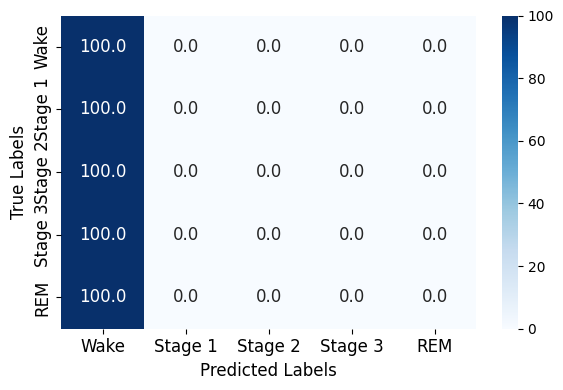

In [39]:
# Step 1: Get predicted labels (argmax on probabilities)
predicted_labels = np.argmax(all_outputs_filtered, axis=1)

fontsize = 12

# Step 2: Compute F1 score for each class
f1_scores = f1_score(all_targets_filtered, predicted_labels, average=None, labels=range(len(class_labels)))
for idx, label in enumerate(class_labels):
    print(f"F1 Score for {label}: {f1_scores[idx]:.3f}")

# Step 3: Create a confusion matrix and normalize it by row to get percentages
conf_matrix = confusion_matrix(all_targets_filtered, predicted_labels, labels=range(len(class_labels)))
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plotting the confusion matrix with percentages
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": fontsize},  # Font size for numbers inside the heatmap
    cbar_kws={"shrink": 1},  # Adjust colorbar size
)

# Customizing axis labels and ticks
plt.xlabel("Predicted Labels", fontsize=fontsize)
plt.ylabel("True Labels", fontsize=fontsize)
plt.xticks(fontsize=12, ha="center")  # Font size for x-axis tick labels with rotation
plt.yticks(fontsize=12)  # Font size for y-axis tick labels

# Adjust layout and save the figure
plt.tight_layout()
plt.show()

#### Part 3: Disease Prediction

In [40]:
disease_model_path = "../sleepfm/checkpoints/model_diagnosis"
config = load_data(os.path.join(disease_model_path, "config.json"))

In [41]:
config["model_params"]["dropout"] = 0.0
model_params = config['model_params']
model_class = getattr(sys.modules[__name__], config['model'])
model = model_class(**model_params).to(device)
model_name = type(model).__name__

In [42]:
model = nn.DataParallel(model)
print(f"Model initialized: {model_name}")
total_layers, total_params = count_parameters(model)
print(f'Trainable parameters: {total_params / 1e6:.2f} million')
print(f'Number of layers: {total_layers}')

Model initialized: DiagnosisFinetuneFullLSTMCOXPHWithDemo
Trainable parameters: 0.91 million
Number of layers: 15


In [43]:
checkpoint_path = os.path.join(disease_model_path, "best.pth")

In [44]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [45]:
class DiagnosisFinetuneFullCOXPHWithDemoDataset(Dataset):
    def __init__(self, 
                 config,
                 channel_groups,
                 hdf5_paths=None,
                 demo_labels_path=None,
                 split="train"):

        self.config = config
        self.channel_groups = channel_groups
        self.max_channels = self.config["max_channels"]

        # --- Load demographic features ---
        if not demo_labels_path:
            demo_labels_path = config["demo_labels_path"]

        demo_labels_df = pd.read_csv(demo_labels_path)
        demo_labels_df = demo_labels_df.set_index("Study ID")
        study_ids = set(demo_labels_df.index)

        is_event_df = pd.read_csv(os.path.join(self.config["labels_path"], "is_event.csv"))
        event_time_df = pd.read_csv(os.path.join(self.config["labels_path"], "time_to_event.csv"))

        is_event_df = is_event_df.set_index('Study ID')
        event_time_df = event_time_df.set_index('Study ID')

        # --- Resolve HDF5 paths (explicit precedence) ---
        if hdf5_paths:
            # Use provided paths directly
            hdf5_paths = [f for f in hdf5_paths if os.path.exists(f)]
        else:
            # Load from split file
            split_paths = load_data(config["split_path"])[split]
            hdf5_paths = [f for f in split_paths if os.path.exists(f)]

        # Filter by available demo labels
        hdf5_paths = [
            f for f in hdf5_paths
            if os.path.basename(f).split(".")[0] in study_ids
        ]

        # Optional truncation
        if config.get("max_files"):
            hdf5_paths = hdf5_paths[:config["max_files"]]

        labels_dict = {}
        # Loop over each study_id
        for study_id in tqdm.tqdm(study_ids):
            # Extract the row as a whole for both dataframes (faster than iterating over columns)
            is_event_row = list(is_event_df.loc[study_id].values)
            event_time_row = list(event_time_df.loc[study_id].values)
            demo_feats = list(demo_labels_df.loc[study_id].values)

            # values = [[event_time, is_event] for is_event, event_time in zip(is_event_row, event_time_row)]
            labels_dict[study_id] = {
                "is_event": is_event_row,
                "event_time": event_time_row, 
                "demo_feats": demo_feats
            }

        # --- Build index map ---
        self.index_map = [
            (path, labels_dict[os.path.basename(path).split(".")[0]])
            for path in hdf5_paths
        ]

        print(f"Number of files in {split} set: {len(hdf5_paths)}")
        print(f"Number of files to be processed in {split} set: {len(self.index_map)}")

        self.total_len = len(self.index_map)
        self.max_seq_len = config["model_params"]["max_seq_length"]

        if self.total_len == 0:
            raise ValueError(f"No valid HDF5 files found for split='{split}'.")

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        hdf5_path, tte_event = self.index_map[idx]

        event_time = tte_event["event_time"]
        is_event = tte_event["is_event"]
        demo_feats = tte_event["demo_feats"]

        x_data = []
        with h5py.File(hdf5_path, 'r') as hf:
            dset_names = []
            for dset_name in hf.keys():
                if isinstance(hf[dset_name], h5py.Dataset) and dset_name in self.config["modality_types"]:
                    dset_names.append(dset_name)
            
            random.shuffle(dset_names)
            for dataset_name in dset_names:
                x_data.append(hf[dataset_name][:])

        if not x_data:
            # Skip this data point if x_data is empty
            return self.__getitem__((idx + 1) % self.total_len)

        # Convert x_data list to a single numpy array
        x_data = np.array(x_data)

        # Convert x_data to tensor
        x_data = torch.tensor(x_data, dtype=torch.float32)

        event_time = torch.tensor(event_time, dtype=torch.float32)
        is_event = torch.tensor(is_event) 

        demo_feats = torch.tensor(demo_feats, dtype=torch.float32)

        return x_data, event_time, is_event, demo_feats, self.max_channels, self.max_seq_len, hdf5_path


def diagnosis_finetune_full_coxph_with_demo_collate_fn(batch):
    x_data, event_time, is_event, demo_feats, max_channels_list, max_seq_len_list, hdf5_path_list = zip(*batch)

    num_channels = max(max_channels_list)

    if max_seq_len_list[0] == None:
        max_seq_len = max([item.size(1) for item in x_data])
    else:
        max_seq_len = max_seq_len_list[0]

    padded_x_data = []
    padded_mask = []
    for item in x_data:
        c, s, e = item.size()
        c = min(c, num_channels)
        s = min(s, max_seq_len)  # Ensure the sequence length doesn't exceed max_seq_len

        # Create a padded tensor and a mask tensor
        padded_item = torch.zeros((num_channels, max_seq_len, e))
        mask = torch.ones((num_channels, max_seq_len))

        # Copy the actual data to the padded tensor and set the mask for real data
        padded_item[:c, :s, :e] = item[:c, :s, :e]
        mask[:c, :s] = 0  # 0 for real data, 1 for padding

        padded_x_data.append(padded_item)
        padded_mask.append(mask)
    
    # Stack all tensors into a batch
    x_data = torch.stack(padded_x_data)
    event_time = torch.stack(event_time)
    is_event = torch.stack(is_event)
    demo_feats = torch.stack(demo_feats)
    padded_mask = torch.stack(padded_mask)
    
    return x_data, event_time, is_event, demo_feats, padded_mask, hdf5_path_list

In [46]:
save_path = os.path.join(base_save_path, "demo_diagnosis")
os.makedirs(save_path, exist_ok=True)

In [47]:
hdf5_paths = [os.path.join(base_save_path, "demo_emb/demo_psg.hdf5")]
demo_labels_path = os.path.join(base_save_path, "demo_age_gender.csv")
config["labels_path"] = base_save_path

test_dataset = DiagnosisFinetuneFullCOXPHWithDemoDataset(config, channel_groups, split="test", hdf5_paths=hdf5_paths, demo_labels_path=demo_labels_path)

100%|██████████| 1/1 [00:00<00:00, 1963.63it/s]

Number of files in test set: 1
Number of files to be processed in test set: 1


In [48]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, collate_fn=diagnosis_finetune_full_coxph_with_demo_collate_fn)

In [49]:
model.eval()
all_event_times = []
all_is_event = []
all_outputs = []
all_paths = []

with torch.no_grad():
    for item in tqdm.tqdm(test_loader, desc="Evaluating"):
        x_data, event_times, is_event, demo_feats, padded_matrix, hdf5_path_list = item
        x_data, event_times, is_event, demo_feats, padded_matrix, hdf5_path_list = x_data.to(device), event_times.to(device), is_event.to(device), demo_feats.to(device), padded_matrix.to(device), list(hdf5_path_list)
        outputs = model(x_data, padded_matrix, demo_feats)
    
        logits = outputs.cpu().numpy()
        all_outputs.append(logits)
        all_event_times.append(event_times.cpu().numpy())
        all_is_event.append(is_event.cpu().numpy())
        all_paths.append(hdf5_path_list)

all_outputs = np.concatenate(all_outputs, axis=0)
all_event_times = np.concatenate(all_event_times, axis=0)
all_is_event = np.concatenate(all_is_event, axis=0)
all_paths = np.concatenate(all_paths)

outputs_path = os.path.join(save_path, "all_outputs.pickle")
event_times_path = os.path.join(save_path, "all_event_times.pickle")
is_event_path = os.path.join(save_path, "all_is_event.pickle")
file_paths = os.path.join(save_path, "all_paths.pickle")

save_data(all_outputs, outputs_path)
save_data(all_event_times, event_times_path)
save_data(all_is_event, is_event_path)
save_data(all_paths, file_paths)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]/home/nummm/Documents/CEPP/sleepfm-clinical/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


In [50]:
all_outputs.shape, all_event_times.shape, all_is_event.shape

((1, 1065), (1, 1065), (1, 1065))

Above, you get the model outputs, which you can then use to look for specific disease diagnosis. Nope that the shape of the output above is 1065, meaning, this model gives logprobs for 1065 conditions. We provide information about each disease index and its corresponding phecode here `sleepfm/configs/label_mapping.csv`. You can map it as follows. 

In [51]:
labels_df = pd.read_csv("../sleepfm/configs/label_mapping.csv")

In [52]:
labels_df["output"] = all_outputs[0]
labels_df["is_event"] = all_is_event[0]
labels_df["event_time"] = all_event_times[0]

#### 🏥 Phase 3B: Phecode Coverage

Counts how many diseases (Unique Phecodes) have a predicted hazard above `HAZARD_THRESHOLD`.

In [53]:
# _info("Phase 3B — Phecode Coverage")

# _hazard_outputs = all_outputs[0]   # shape: (n_phecodes,)
# _above_mask     = _hazard_outputs > HAZARD_THRESHOLD
# _n_above        = int(_above_mask.sum())
# _n_total        = len(_hazard_outputs)

# print(f"  Hazard threshold  : \033[1m{HAZARD_THRESHOLD}\033[0m")
# print(f"  Phecodes above    : \033[1;33m{_n_above}\033[0m / {_n_total} ({_n_above/_n_total*100:.1f}%)")

# if _n_above == 0:
#     _warn("No phecodes above threshold — consider lowering HAZARD_THRESHOLD")
# else:
#     _ok(f"{_n_above} phecodes with hazard > {HAZARD_THRESHOLD}")

# if DEBUG:
#     _cov_df = labels_df.copy()
#     _cov_df["above_threshold"] = _above_mask
#     _top_df = (_cov_df[_cov_df["above_threshold"]]
#                [["phecode", "phenotype", "output"]]
#                .sort_values("output", ascending=False)
#                .reset_index(drop=True))

#     display(_top_df.style
#         .format({"output": "{:.4f}"})
#         .bar(subset=["output"], color="#f4a261")
#         .set_caption(f"🏥 Phecodes with Hazard > {HAZARD_THRESHOLD} (Phase 3B)")
#         .set_table_styles([{"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold")]}]))
# else:
#     _info(f"Phecode detail table suppressed (DEBUG=False). {_n_above} phecodes above threshold.")


In [54]:
labels_df.head()

,label_idx,phecode,phenotype,output,is_event,event_time
0,0,8.0,Intestinal infection,2.382297,0,3845.0
1,1,8.5,Bacterial enteritis,2.941346,0,3845.0
2,2,8.6,Viral Enteritis,3.220719,0,3845.0
3,3,38.0,Septicemia,5.640467,0,3845.0
4,4,38.3,Bacteremia,5.597489,0,3845.0


Above, you get the output hazards from our model, and also your labels for is_event and event_times. Is_event is an indicator for if the event occured and event_time is the time to event